<a href="https://colab.research.google.com/github/HEKOCMOC/HPC_LAB/blob/main/MatMul/Matrix_multiplication.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
!pip install py-cpuinfo

     |████████████████████████████████| 99 kB 3.5 MB/s 
  Created wheel for py-cpuinfo: filename=py_cpuinfo-8.0.0-py3-none-any.whl size=22258 sha256=dab06f45edd60a76d6261caa5576097badbb07fbc64391b1dd924e2d36e56e31
  Stored in directory: /root/.cache/pip/wheels/d2/f1/1f/041add21dc9c4220157f1bd2bd6afe1f1a49524c3396b94401
Successfully built py-cpuinfo


In [3]:
import math
import numpy as np
from numba import cuda, jit, float64
import time
import pandas as pd
import cpuinfo 

print('CPU, выделенный на сервере Colab:', cpuinfo.get_cpu_info()['brand_raw'])
print('GPU, выделенный на сервере Colab:', cuda.get_current_device())

CPU, выделенный на сервере Colab: Intel(R) Xeon(R) CPU @ 2.30GHz
GPU, выделенный на сервере Colab: <CUDA device 0 'b'Tesla K80''>


In [4]:
N0 = 50
A0 = np.random.randn(N0, N0)
B0 = np.random.randn(N0, N0)
C0 = np.zeros((N0, N0))

In [5]:
N1 = 128
A1 = np.random.randn(N1, N1)
B1 = np.random.randn(N1, N1)
C1 = np.zeros((N1, N1))

In [6]:
N2 = 500
A2 = np.random.randn(N2, N2)
B2 = np.random.randn(N2, N2)
C2 = np.zeros((N2, N2))

In [7]:
def CPU_matmul_dot(A, B):
  C = np.dot(A,B)

s1 = time.time()
CPU_matmul_dot(A0, B0)
host_0 = C0
end0 = time.time() - s1
print(' -----------------------------------')
print('| Matmul on CPU (np.dot): {:.3f}'.format(end0), 'sec.|')
print(' -----------------------------------')

s2 = time.time()
CPU_matmul_dot(A1, B1)
end1 = time.time() - s2
print(' -----------------------------------')
print('| Matmul on CPU (np.dot): {:.3f}'.format(end1), 'sec.|')
print(' -----------------------------------')

s3 = time.time()
CPU_matmul_dot(A2, B2)
end2 = time.time() - s3
print(' -----------------------------------')
print('| Matmul on CPU (np.dot): {:.3f}'.format(end2), 'sec.|')
print(' -----------------------------------')

 -----------------------------------
| Matmul on CPU (np.dot): 0.004 sec.|
 -----------------------------------
 -----------------------------------
| Matmul on CPU (np.dot): 0.003 sec.|
 -----------------------------------
 -----------------------------------
| Matmul on CPU (np.dot): 0.014 sec.|
 -----------------------------------


In [8]:
def CPU_matmul(A, B, C):
  for i in range(C.shape[0]):
    for j in range(C.shape[1]):
      sum = 0
      for k in range(A.shape[1]):
        sum += A[i, k] * B[k, j]
      C[i, j] = sum

host_1 = C0

s4 = time.time()
CPU_matmul(A0, B0, C0)
end3 = time.time() - s4
print(' --------------------------')
print('| Matmul on CPU: {:.3f}'.format(end3), 'sec.|')
print(' --------------------------')

s5 = time.time()
CPU_matmul(A1, B1, C1)
end4 = time.time() - s5
print(' --------------------------')
print('| Matmul on CPU: {:.3f}'.format(end4), 'sec.|')
print(' --------------------------')

s6 = time.time()
CPU_matmul(A2, B2, C2)
end5 = time.time() - s6
print(' ---------------------------')
print('| Matmul on CPU: {:.3f}'.format(end5), 'sec.|')
print(' ---------------------------')

 --------------------------
| Matmul on CPU: 0.113 sec.|
 --------------------------
 --------------------------
| Matmul on CPU: 1.429 sec.|
 --------------------------
 ---------------------------
| Matmul on CPU: 79.691 sec.|
 ---------------------------


In [9]:
@jit
def CPU_matmul_jit(A, B, C):
  for i in range(C.shape[0]):
    for j in range(C.shape[1]):
      sum = 0
      for k in range(A.shape[1]):
        sum += A[i, k] * B[k, j]
      C[i, j] = sum

host_2 = C0

s7 = time.time()
CPU_matmul_jit(A0, B0, C0)
end6 = time.time() - s7
print(' --------------------------------')
print('| Matmul on CPU (jit): {:.3f}'.format(end6), 'sec.|')
print(' --------------------------------')

s8 = time.time()
CPU_matmul_jit(A1, B1, C1)
end7 = time.time() - s8
print(' --------------------------------')
print('| Matmul on CPU (jit): {:.3f}'.format(end7), 'sec.|')
print(' --------------------------------')

s9 = time.time()
CPU_matmul_jit(A2, B2, C2)
end8 = time.time() - s9
print(' --------------------------------')
print('| Matmul on CPU (jit): {:.3f}'.format(end8), 'sec.|')
print(' --------------------------------')

 --------------------------------
| Matmul on CPU (jit): 0.467 sec.|
 --------------------------------
 --------------------------------
| Matmul on CPU (jit): 0.003 sec.|
 --------------------------------
 --------------------------------
| Matmul on CPU (jit): 0.182 sec.|
 --------------------------------


In [10]:
@cuda.jit
def GPU_matmul_cuda_jit(A, B, C):
  i, j = cuda.grid(2)
  if i < C.shape[0] and j < C.shape[1]:
    sum = 0
    for k in range(A.shape[1]):
      sum += A[i, k] * B[k, j]
      C[i, j] = sum


def host_naive(A, B, C):
  d_A = cuda.to_device(A)
  d_B = cuda.to_device(B)
  d_C = cuda.device_array(C.shape, np.float64)

  threadsperblock = (32, 32)
  blockspergrid_x = math.ceil(A.shape[0]/threadsperblock[0])
  blockspergrid_y = math.ceil(B.shape[1]/threadsperblock[1])
  blockspergrid = (blockspergrid_x, blockspergrid_y)

  GPU_matmul_cuda_jit[blockspergrid, threadsperblock](d_A, d_B, d_C)
  return d_C.copy_to_host()


cuda.select_device(0) #выбор устройства GPU
s10 = time.time()
host_naive(A0, B0, C0)
host_3 = C0
end9 = time.time() - s10
print(' --------------------------')
print('| Matmul on GPU: {:.3f}'.format(end9), 'sec.|')
print(' --------------------------')

cuda.select_device(0)
s11 = time.time()
host_naive(A1, B1, C1)
end10 = time.time() - s11
print(' --------------------------')
print('| Matmul on GPU: {:.3f}'.format(end10), 'sec.|')
print(' --------------------------')

cuda.select_device(0)
s12 = time.time()
host_naive(A2, B2, C2)
end11 = time.time() - s12
print(' --------------------------')
print('| Matmul on GPU: {:.3f}'.format(end11), 'sec.|')
print(' --------------------------')

 --------------------------
| Matmul on GPU: 0.573 sec.|
 --------------------------
 --------------------------
| Matmul on GPU: 0.005 sec.|
 --------------------------
 --------------------------
| Matmul on GPU: 0.065 sec.|
 --------------------------


In [11]:
assert np.allclose(host_0, host_3)
assert np.allclose(host_1, host_3)
assert np.allclose(host_2, host_3)

In [12]:
timing_df = pd.DataFrame({'Name':['CPU', 'CPU(dot)', 'CPU(jit)' ,'GPU', 'CPU', 'CPU(dot)', 'CPU(jit)' ,'GPU', 'CPU', 'CPU(dot)', 'CPU(jit)' ,'GPU'], 'Time(s)':[end0, end3, end6, end9, end1, end4, end7, end10, end2, end5, end8, end11], 'Matrix size':[N0, N0, N0, N0, N1, N1, N1, N1, N2, N2, N2, N2]})
timing_df

,Name,Time(s),Matrix size
0,CPU,0.004347,50
1,CPU(dot),0.113307,50
2,CPU(jit),0.466617,50
3,GPU,0.573427,50
4,CPU,0.002797,128
5,CPU(dot),1.428675,128
6,CPU(jit),0.002504,128
7,GPU,0.005052,128
8,CPU,0.013502,500
9,CPU(dot),79.690752,500


In [13]:
acc = pd.DataFrame({'Acceleration (CPU/GPU)':[end3/end9, end4/end10, end5/end11], 'Acceleration (dot/GPU)':[end0/end9, end1/end10, end2/end11], 'Acceleration (jit/GPU)':[end6/end9, end7/end10, end8/end11]})
acc

,Acceleration (CPU/GPU),Acceleration (dot/GPU),Acceleration (jit/GPU)
0,0.197595,0.007581,0.813735
1,282.802303,0.553589,0.495635
2,1233.712422,0.209022,2.812271


In [14]:
import matplotlib.pyplot as plt

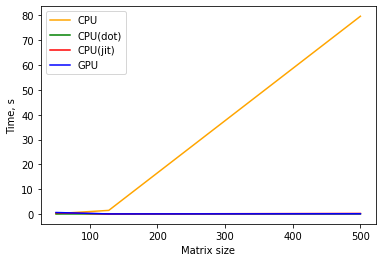

In [15]:
plt.plot([N0, N1, N2], [end3, end4, end5], color = 'orange', label = 'CPU')
plt.plot([N0, N1, N2], [end0, end1, end2], color = 'green', label = 'CPU(dot)')
plt.plot([N0, N1, N2], [end6, end7, end8], color = 'red' , label = 'CPU(jit)')
plt.plot([N0, N1, N2], [end9, end10, end11], color = 'blue', label = 'GPU')
plt.rcParams['figure.facecolor'] = 'white'
plt.xlabel('Matrix size')
plt.ylabel('Time, s')
plt.legend()